In my senior thesis (https://github.com/samtaplin/thesis), I investigated multiparty elections held by authoritarian regimes. To my surprise, I  found no statistically significant correlation between a regime's relative level of electoral democracy (per the Varieties of Democracy Institute's electoral democracy index) and the opposition's chances of winning the election. This finding contradicts what seems like a very common-sense idea about authoritarianism: highly authoritarian leaders should have more power to manipulate elections in their favor and should therefore be less likely to lose them.

In [2]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn import cluster
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set(rc={'figure.figsize':(10,6)})

To explain my finding, let's take another look at the elections data from my thesis:

In [3]:
data = pd.read_csv('cleanedout.csv')

From the histogram below, we can see that a country's level of electoral democracy is a poor predictor of the opposition's likelihood of winning the election.

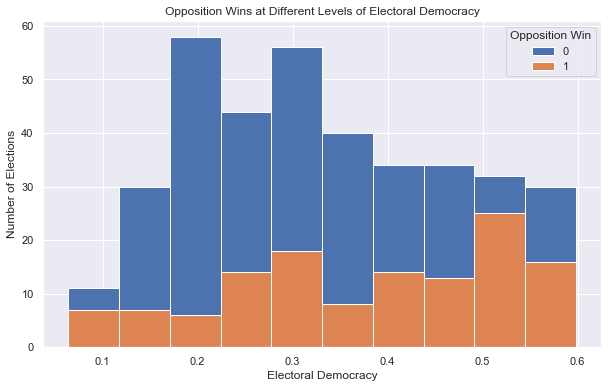

In [4]:
data.pivot(columns="Opposition Win", values="v2x_polyarchy").plot.hist();
plt.xlabel("Electoral Democracy");
plt.ylabel("Number of Elections");
plt.title('Opposition Wins at Different Levels of Electoral Democracy');

(Note I only considered multiparty elections at electoral democracy levels of 0.6 and below. See the case-selection section of my thesis for more details. In total, my dataset includes 497 elections between 1946 and 2013.)

I explained this counterintutive finding by postulating that authoritarian governments may only resort to extremely repressive behavior when seriously threatened. A regime's unpopularity might explain both its use of high levels of repression and its surprisingly high likelihood of electoral defeat given that repression. Popular authoritarian governments, on the other hand, don't need to be so repressive.

Low levels of electoral democracy might represent the regime's strategy for winning the election instead of some deep unchanging fact about the regime. Put another way, I argued that an authoritarian leader's strategy for survival determines the relative-authoritarianness of the regime. I ultimately broke authoritarian strategies for winning reelection down into two broad categories. Some try to survive by pretending to be democratic, growing the economy and staying popular. Others stay in power by being as authoritarian as possible and scaring their opponents into submission. I called the first group 'Peacocks' and the second group 'Vipers'.  

Of course, I assume that a regime can dial-up and dial-down the amount of repression it employs. In reality, regimes <a href='https://www.cambridge.org/core/journals/american-political-science-review/article/abs/deliver-the-vote-micromotives-and-macrobehavior-in-electoral-fraud/348D3A1DB751D4D4C91ABCDE2056F15E'>may struggle</a> to do so.

I had this to say about Peacocks:


'These authoritarian regimes eagerly seek international legitimation, take pains to appear as democratic as possible, showcase all the ways they work for the welfare of their citizens, and make sure not to reveal any hint of instability. They stay popular and make sure everyone knows how popular they are. I call them Peacocks. Like a peacock’s feathers, these impressive adornments are hard to fake. Only regimes with deep-pockets and a cohesive ruling coalition can afford to invest in their people and impress international audiences. Media control, narrowly targeted repression, (Dragu and Przeworski 2018) genuine popular support and their carefully cultivated appearance of invincibility help them avoid depending on brute repression too much.'


Here's my description of Vipers:

'Highly authoritarian regimes win elections by making the costs of opposition electoral participation too high for them (the opposition) to sustain. The strong relationship between the relative authoritarianism of a regime and the likelihood of boycotts supports this connection. Like vipers, these regimes rely on venom to subdue and scare their challengers. However, when a regime uses violence against its own citizens, it may lose popular support and international legitimacy.'

However, resorting to a Viper-strategy can be dangerous:

'Dictators who rely on brute force come to depend on their military or security forces, giving those groups enormous leverage over them. For this reason, some dictators only resort to mass repression when they're in danger of being replaced.'


So let's look for quantitative evidence of this dichotomy. First, I'll clean up the structure of the dataset.

In [5]:
data.columns

Index(['Unnamed: 0', 'country_x', 'Opposition Challenge', 'OppBoycott', 'year',
       'client', 'PollsBad', 'PollsGood', 'IncumbentRan', 'GoodEcon',
       'polcomp', 'adjexconst', 'IOScore', 'reltradelog', 'transition',
       'PostCW', 'Opposition Win', 'Transitional', 'OppGain', 'EconCrisis',
       'exconst', 'tenure', 'leverage', 'Harrass', 'Rentier', 'v2x_polyarchy',
       'ViolenceAfter', 'Violence', 'PostProtestFraud', 'longten',
       'Major Aid Recipient'],
      dtype='object')

In [6]:
data.index = data[['country_x', 'year']]

I include columns on whether the opposition boycotted, whether the opposition won, whether the regime was a client state of an outside power, regime polling performance (if there were reliable polls), whether the incumbent leader ran for relection (if not, they tapped a chosen-successor), economic performance, institutional constraints of the execute, an index of membership in liberal international organizations (IOScore), levels of trade with major democracies (reltradelog), whether the country was going through a transitional period, whether the election happened after the end of the cold war (PostCW), the incumbent's tenure length, whether the opposition was harrassed, whether the government recieved significant outside economic aid (rentier), the level of electoral democracy in the country(v2x_polyarchy), whether the government used violence against post-election protesters (if there were any), whether the government used violence at any point in the election process, and whether there were post-election protests against fraud.

In [7]:
data['transitions'] = data['transition'] | data['Transitional']
forcluster = data[['OppBoycott', 'Opposition Win',
       'client', 'PollsBad', 'PollsGood', 'IncumbentRan', 'GoodEcon',
        'adjexconst', 'IOScore', 'reltradelog', 'transitions',
       'PostCW', 'EconCrisis', 'tenure', 
        'Harrass', 'Rentier', 'v2x_polyarchy',
       'ViolenceAfter', 'Violence', 'PostProtestFraud']]

I adjust each of my continous variables to match the 0 to 1 scale of my discrete variables. For tenure, trade, and international organization membership, a value of 0.99 respresents a 99th-percentile score relative to other elections in the dataset.

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
sz = forcluster['tenure'].size-1
forcluster['tenure'] = forcluster['tenure'].rank(method='max').apply(lambda x: (x-1)/sz)
forcluster['reltradelog'] = forcluster['reltradelog'].rank(method='max').apply(lambda x: (x-1)/sz)
forcluster['IOScore'] = forcluster['tenure'].rank(method='max').apply(lambda x: (x-1)/sz)
forcluster['adjexconst'] = ((forcluster['adjexconst'] - 1.5) / 5.5)

Next, I create three clusters of elections using k-means clustering.

In [10]:
kmeans_nelda = cluster.KMeans(n_clusters=3, random_state=42).fit(forcluster)

I also creates indices of 'Peacock' and 'Viper' behavior to see if they match my clusters. I assume that 'Viper' regimes will tend to harrass opposition parties, and use violence during and after the election. I figure that peacocks on the other hand, will maintain economic success, participate in trade with democracies and join international organizations. I also assume that vipers will have low electoral-democracy scores.

In [11]:
forcluster['viper'] = forcluster['Harrass'] * 0.25 + forcluster['ViolenceAfter'] * 0.25 + 0.25 * forcluster['Violence'] \
+ 0.25 * (0.6 - forcluster['v2x_polyarchy']) * (4/3)
forcluster['peacock'] = forcluster['GoodEcon'] * 0.25 + (1 - forcluster['EconCrisis']) * 0.25 \
+ 0.25 * forcluster['reltradelog'] + 0.25 * forcluster['IOScore']


Now let's see how K-means grouped our elections!

In [12]:
labeled_forcluster = forcluster.copy()
labeled_forcluster['cluster'] = kmeans_nelda.labels_

Here are the elections in the first cluster listed by country (for the fifteen countries with the most elections in the cluster):

In [33]:
def listbycluster(cluster, n):
    countries = list(map(lambda tup: tup[0], list(labeled_forcluster.query('cluster == ' + str(cluster)).index)))
    bycountry = {}
    for country in countries:
        if country in bycountry:
            bycountry[country] += 1
        else:
            bycountry[country] = 1
    return list(map(lambda item: item[0] + ': ' + str(item[1]), sorted(bycountry.items(), key=lambda x: -x[1])))[:15]
listbycluster(0, 15)

['Thailand: 11',
 'Malaysia: 11',
 'Singapore: 9',
 'Colombia: 7',
 'Turkey: 7',
 'Mexico: 6',
 'El Salvador: 6',
 'Paraguay: 6',
 'South Korea: 6',
 'Dominican Republic: 4',
 'Nicaragua: 4',
 'Guyana: 4',
 'Zambia: 4',
 'South Africa: 4',
 'Lebanon: 4']

The second cluster:

In [34]:
listbycluster(1, 15)

['Philippines: 6',
 'Zimbabwe: 5',
 'South Africa: 5',
 'Dominican Republic: 4',
 'Guatemala: 4',
 'Panama: 4',
 'Albania: 4',
 'Honduras: 3',
 'Argentina: 3',
 'Cambodia: 3',
 'Mexico: 2',
 'El Salvador: 2',
 'Guyana: 2',
 'Peru: 2',
 'Russia (Soviet Union): 2']

And the third cluster:

In [35]:
listbycluster(2, 15)

['Albania: 8',
 'Macedonia (FYROM): 6',
 'Jamaica: 5',
 'Armenia: 5',
 'Central African Republic: 5',
 'Turkey: 5',
 'Guatemala: 4',
 'Croatia: 4',
 'Greece: 4',
 'Russia (Soviet Union): 4',
 'Burkina Faso: 4',
 'Madagascar: 4',
 'Nepal: 4',
 'Solomon Islands: 4',
 'Nicaragua: 3']

Elections in our first cluster are almost all elections where the country's economy was doing well. Less than 20% of the elections featured any form of violence, the opposition boycotted only around 10% of the elections, but was only able to win only about 20% of them. The regime polls well more often than it polls badly.

In [16]:
labeled_forcluster.query('cluster == 0').mean()

OppBoycott          0.123596
Opposition Win      0.213483
client              0.117978
PollsBad            0.089888
PollsGood           0.241573
IncumbentRan        0.752809
GoodEcon            0.960674
adjexconst          0.433095
IOScore             0.568526
reltradelog         0.555398
transitions         0.073034
PostCW              0.471910
EconCrisis          0.022472
tenure              0.568526
Harrass             0.219101
Rentier             0.595506
v2x_polyarchy       0.330343
ViolenceAfter       0.056180
Violence            0.157303
PostProtestFraud    0.134831
viper               0.198032
peacock             0.765532
cluster             0.000000
dtype: float64

Here's a look at our discrete variables:

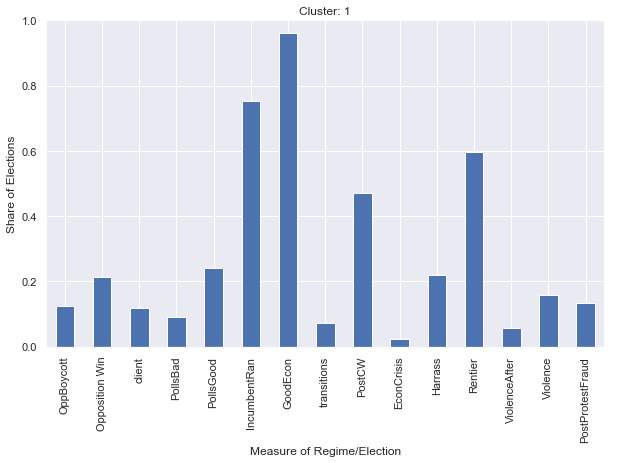

In [17]:
def graphdiscrete(cluster):
    labeled_forcluster.query('cluster == ' + str(cluster - 1)).drop(['v2x_polyarchy', 'IOScore', 
                                                            'reltradelog', 'adjexconst', 'viper', 
                                               'peacock', 'tenure', 'cluster'], axis=1).mean().plot(kind='bar')
    plt.xlabel("Measure of Regime/Election");
    plt.ylabel("Share of Elections");
    plt.title('Cluster: ' + str(cluster));
    plt.ylim(0, 1);
graphdiscrete(1)

And here are our continous indexes:

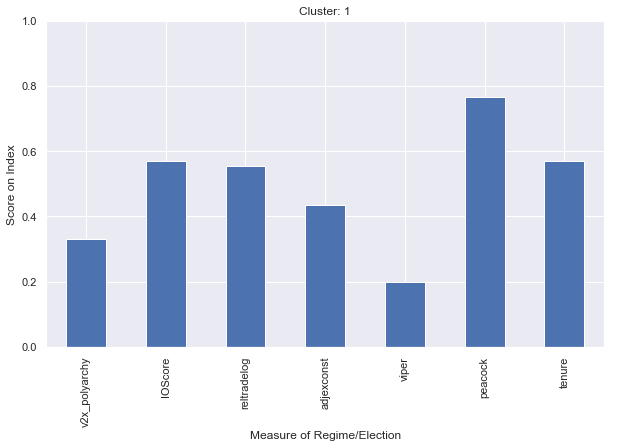

In [18]:
def graphcontinuous(cluster):
    labeled_forcluster.query('cluster == ' + str(cluster - 1))[['v2x_polyarchy', 
                                                                'IOScore', 'reltradelog', 'adjexconst', 'viper', 
                                               'peacock', 'tenure']].mean().plot(kind='bar')
    plt.xlabel("Measure of Regime/Election");
    plt.ylabel("Score on Index");
    plt.title('Cluster: ' + str(cluster));
    plt.ylim(0, 1);
graphcontinuous(1)

As we can see, our first cluster seems to correspond to peacock-like regime strategies. They don't seem to rely on violence the way a viper-like regime would.

Here's cluster two:

In these elections, opposition boycotts are common and violence is extremely common. Most of these elections happen in countries that are performing poorly economically. The polls aren't great for most regimes, but they end up winning 86% of the elections anyway. Our measure of electoral democracy (v2x_polyarchy) is slightly lower than it was for the previous cluster.

In [19]:
labeled_forcluster.query('cluster == 1').mean()

OppBoycott          0.271186
Opposition Win      0.144068
client              0.135593
PollsBad            0.118644
PollsGood           0.152542
IncumbentRan        0.737288
GoodEcon            0.161017
adjexconst          0.390986
IOScore             0.565422
reltradelog         0.494464
transitions         0.093220
PostCW              0.644068
EconCrisis          0.372881
tenure              0.565422
Harrass             0.635593
Rentier             0.762712
v2x_polyarchy       0.313102
ViolenceAfter       0.567797
Violence            0.881356
PostProtestFraud    0.652542
viper               0.616819
peacock             0.462005
cluster             1.000000
dtype: float64

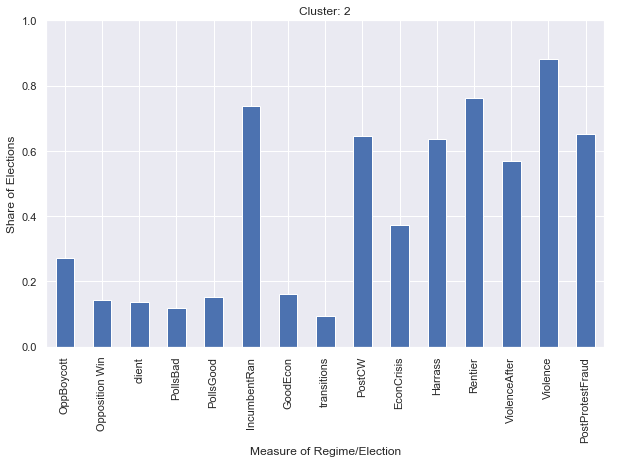

In [20]:
graphdiscrete(2)

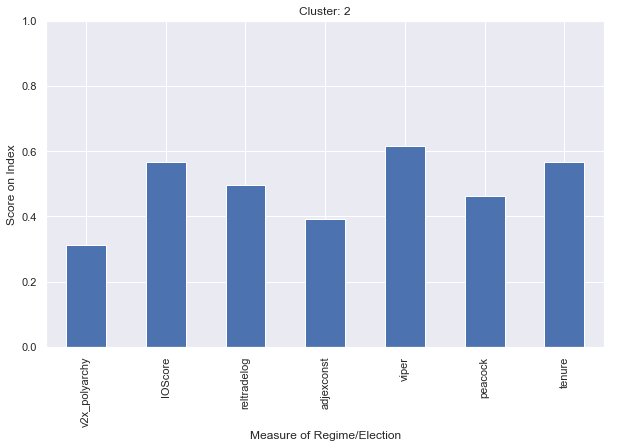

In [21]:
graphcontinuous(2)

As we can see, our 'viper' index is much higher for this group. It looks like these are our vipers.

Finally, we have a third group of elections. In these elections, they opposition wins 36% of the time. As many elections have bad polling for the incumbent as have good polling. And the government generally refrains from violence as well. Pre-election economic performance is poor.

In [22]:
labeled_forcluster.query('cluster == 2').mean()

OppBoycott          0.124378
Opposition Win      0.363184
client              0.089552
PollsBad            0.199005
PollsGood           0.199005
IncumbentRan        0.840796
GoodEcon            0.000000
adjexconst          0.523971
IOScore             0.493280
reltradelog         0.456769
transitions         0.228856
PostCW              0.741294
EconCrisis          0.422886
tenure              0.493280
Harrass             0.144279
Rentier             0.865672
v2x_polyarchy       0.376080
ViolenceAfter       0.000000
Violence            0.208955
PostProtestFraud    0.054726
viper               0.162949
peacock             0.381791
cluster             2.000000
dtype: float64

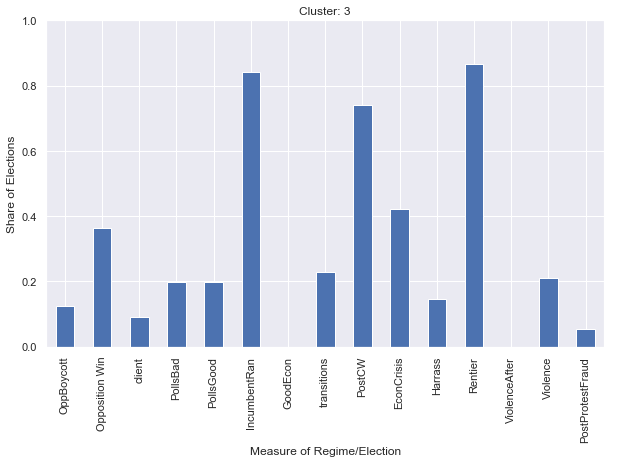

In [23]:
graphdiscrete(3)

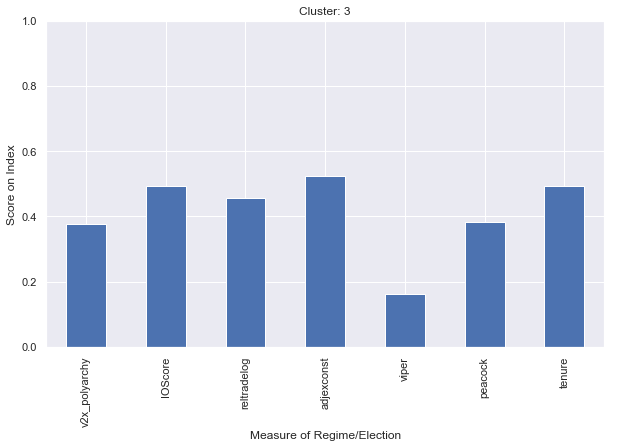

In [24]:
graphcontinuous(3)

In these elections, the government didn't adopt a peacock or a viper strategy. They averaged a peacock index below that of my peacock cluster and a very low viper index. It isn't surprising that many of these regimes lost. Without the ability to either improve the lives of most citizens or really repress them, these authoritarian leaders are vulnerable to overthrow.

Here's a scatterplot of every election's score on our peacock and viper indices. The absolute scores are not particularly meaningful, but they serve as a useful point of comparison relative to each other.

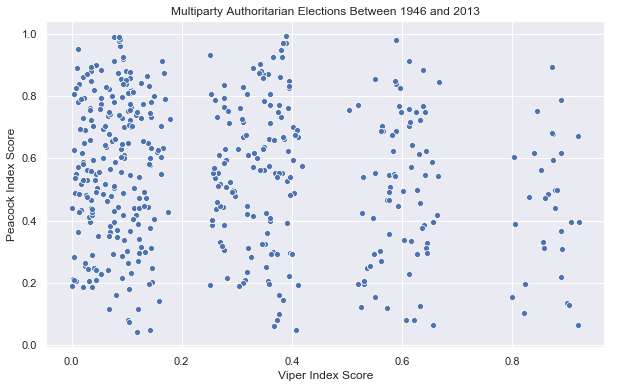

In [25]:
sns.scatterplot(x=labeled_forcluster['viper'], y=labeled_forcluster['peacock']);
plt.xlabel("Viper Index Score");
plt.ylabel("Peacock Index Score");
plt.title('Multiparty Authoritarian Elections Between 1946 and 2013');

Now here's the same plot, with each election labelled by the cluster that it's in. Recall that the opposition did best in elections that were part of cluster 2.

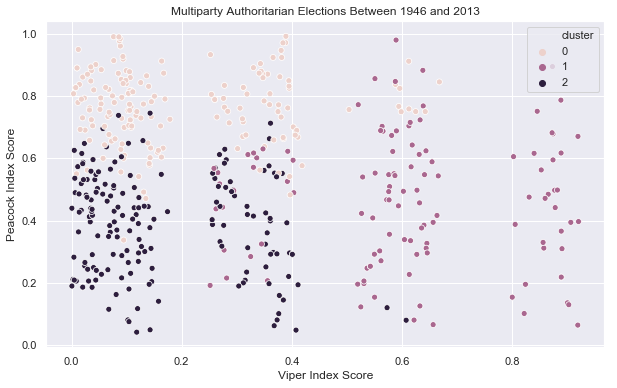

In [26]:
sns.scatterplot(x=labeled_forcluster['viper'], y=labeled_forcluster['peacock'], hue=labeled_forcluster['cluster'])
plt.xlabel("Viper Index Score");
plt.ylabel("Peacock Index Score");
plt.title('Multiparty Authoritarian Elections Between 1946 and 2013');

I include my viper and peacock indexes in a fairly simple logistic regression model, with the other regime measures that I found predictive of opposition success. As I expected, both high viper scores and high peacock scores are negatively correlated with opposition success. However, the peacock index isn't correlated with opposition wins at a 95% significance level.

In [27]:
logtesting = forcluster[['viper', 'PollsGood', 'peacock', 'IncumbentRan', 'tenure', 'Rentier']]
outcome = forcluster[['Opposition Win']]
log_res = sm.Logit(outcome, sm.add_constant(logtesting)).fit(disp=0)

In [28]:
print(log_res.summary())

                           Logit Regression Results                           
Dep. Variable:         Opposition Win   No. Observations:                  497
Model:                          Logit   Df Residuals:                      490
Method:                           MLE   Df Model:                            6
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                  0.1388
Time:                        18:30:01   Log-Likelihood:                -244.17
converged:                       True   LL-Null:                       -283.53
Covariance Type:            nonrobust   LLR p-value:                 6.573e-15
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.8048      0.489      3.693      0.000       0.847       2.763
viper           -1.7829      0.499     -3.574      0.000      -2.761      -0.805
PollsGood       -2.2132      0.448     -4.94

In [29]:
outcome = forcluster[['OppBoycott']]
log_res = sm.Logit(outcome, sm.add_constant(logtesting)).fit(disp=0)

Here are the results for the correlations with boycotts. As we'd expect, a high regime viper index predicts a higher likelihood of a boycott.

In [30]:
print(log_res.summary())

                           Logit Regression Results                           
Dep. Variable:             OppBoycott   No. Observations:                  497
Model:                          Logit   Df Residuals:                      490
Method:                           MLE   Df Model:                            6
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                 0.07553
Time:                        18:30:05   Log-Likelihood:                -201.21
converged:                       True   LL-Null:                       -217.65
Covariance Type:            nonrobust   LLR p-value:                 1.106e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.2393      0.654     -6.480      0.000      -5.521      -2.957
viper            1.7610      0.497      3.541      0.000       0.786       2.736
PollsGood       -0.2639      0.350     -0.75

In [31]:
outcome = forcluster[['PostProtestFraud']]
log_res = sm.Logit(outcome, sm.add_constant(logtesting)).fit(disp=0)

And finally, here are my findings for post-election protests. Vipereous regimes tend to set off protests against their handling of the election. In turn, they often use violence against protesters.

In [32]:
print(log_res.summary())

                           Logit Regression Results                           
Dep. Variable:       PostProtestFraud   No. Observations:                  497
Model:                          Logit   Df Residuals:                      490
Method:                           MLE   Df Model:                            6
Date:                Mon, 25 Oct 2021   Pseudo R-squ.:                  0.1814
Time:                        18:30:10   Log-Likelihood:                -217.10
converged:                       True   LL-Null:                       -265.20
Covariance Type:            nonrobust   LLR p-value:                 1.551e-18
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.1184      0.539     -5.789      0.000      -4.174      -2.063
viper            4.2963      0.506      8.487      0.000       3.304       5.289
PollsGood        0.6937      0.298      2.32

So the results aren't entirely clear.

But here are a few hypotheses I believe we can draw from them:

1. If you're an authoritarian leader facing an election you have a pretty good chance of keeping power if one of these three conditions are met:
    
   A: You're running an economically successful country. Whether or not you're responsible for that success, you can certainly claim credit for it. It's dictatorship on easy mode. Of course, depending on whether or not you believe in modernization theory, sustained economic success may weaken your position in the long term. 
   
   B: You're extremely popular for some reason that doesn't have to do with improving your subjects' well-being. Maybe you're super charismatic. Try not to die because you'll be hard to replace.
   
   C: You're willing to resort to harrassment and violence. And the security services will back you up. You'll probably have to deal with tremendous reputational damage and major protests.

2. If you're not economically lucky, super charismatic, or able to dish out some serious violence, you may still manage to win. But you're very much at risk of losing.

3. Highly levels of violent repression are inversely correlated with economic success. Repression may be bad for the economy. Alternatively, dictators of poorly-performing economies may be more likely to resort to violence. I think both are probably true, but that the latter explanation has a bigger effect.

A couple caveats though:

1. Economically successful dictators depend less on external aid. Observe that in my first cluster, only 60% of regimes recieved some form of significant outside aid. In the other clusters, that number is around 80%. It would be reasonable to infer that my peacock index may be in part a proxy for development. And more developed states tend to witness lower levels of violence. So there may not be a tradeoff between violence and economic prosperity, between being a peacock and being a vipers It could be that poorer countries just more violent and less economically successful. (A caveat to that caveat though: the list of peacocks is dominated by countries like Thailand, Singapore and Malaysia that started out poor and became richer. Their regimes' decisions and its strategy for survival preceeded economic development.)

2. The greatest threat to dictators usually comes from other regime insiders. An authoritarian leader may weigh that threat more heavily than the threat of an election when deciding on her strategy for survival.